In [1]:
import time

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from sklearn.neural_network import MLPClassifier
# import lightgbm as lgb
# from catboost import CatBoostClassifier

import momepy
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from sklearn import metrics


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from folium.features import DivIcon
from IPython import display
import ipywidgets as widgets
import folium

In [2]:
pd.options.display.max_columns = None

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
gdf = gpd.read_parquet('duplicate-candidates-1000.parquet')
labels = pd.read_pickle('labeling-progress.pickle').set_index('id')
labels = labels[labels['duplicate'] != 'unsure']
gdf = gdf[gdf['candidate_id'].isin(labels.index)]
gdf['duplicate'] = gdf['candidate_id'].map(labels['duplicate'])



In [5]:
candidates = gdf[gdf.index == gdf['candidate_id']]
gdf['candidate_dataset'] = candidates.loc[gdf['candidate_id']]['dataset'].values
existing_buildings = gdf[gdf['dataset'] != gdf['candidate_dataset']]
new_buildings = gdf[gdf['dataset'] == gdf['candidate_dataset']]
other_new_buildings = new_buildings[new_buildings.index != new_buildings['candidate_id']]


## Preprocessing

### Remove duplicates

In [258]:
gdf = gpd.read_parquet('duplicate-candidates-1000-inc-duplicates.parquet')
gdf = gdf.reset_index().drop_duplicates(subset=['id_source', 'candidate_id']).set_index('id_source').drop_duplicates(subset=['geometry', 'candidate_id'])
gdf = gdf[~gdf['id'].isin(['v1-NLGM0047-3670', 'v1-AT70414-1403'])]  # temporary fix: manually drop 2 buildings with duplicated id_source
gdf.to_parquet('duplicate-candidates-1000.parquet')

### Determining pairs

In [ ]:
    
# ioa_bsc: intersection-over-area before_shift_correction
# existing_buildings['candidate_geometry'] = existing_buildings['candidate_id'].map(candidates['geometry'])
# existing_buildings['ioa_bsc'] = existing_buildings.intersection(existing_buildings['candidate_geometry']).area / np.minimum(existing_buildings.area, existing_buildings['candidate_geometry'].area)
# existing_buildings['match'] = existing_buildings['ioa_bsc'] == existing_buildings.groupby('candidate_id')['ioa_bsc'].transform('max')
# pairs = existing_buildings[existing_buildings['match']]['candidate_id']


/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWith

### Correcting local shift

In [14]:
from shapely.affinity import translate
from scipy.spatial import KDTree

def correct_local_shift(existing_buildings, new_buildings):
    existing_x = existing_buildings.centroid.x.values
    existing_y = existing_buildings.centroid.y.values
    existing_centroids = np.column_stack((existing_x, existing_y))

    new_x = new_buildings.centroid.x.values
    new_y = new_buildings.centroid.y.values
    new_centroids = np.column_stack((new_x, new_y))

    # Build KDTree for fast spatial matching
    tree = KDTree(existing_centroids)
    _, indices = tree.query(new_centroids, distance_upper_bound=25)

    # Compute offset vectors
    valid_mask = indices < len(existing_centroids)

    # Get matched areas
    gov_areas = existing_buildings.area.values[indices[valid_mask]]
    osm_areas = new_buildings.area.values

    # Keep only pairs with footprint area difference ≤ 50% 
    area_ratio = np.minimum(osm_areas[valid_mask] / gov_areas, gov_areas / osm_areas[valid_mask])
    area_mask = area_ratio >= 0.5  
    valid_mask[valid_mask] &= area_mask

    # ------ Method 1: Candidate-based offsets ------
    # Compute offset vectors
    new_buildings["dx"] = np.nan
    new_buildings["dy"] = np.nan
    new_buildings.loc[valid_mask, "dx"] = existing_x[indices[valid_mask]] - new_x[valid_mask]
    new_buildings.loc[valid_mask, "dy"] = existing_y[indices[valid_mask]] - new_y[valid_mask]

    # Compute regional average offsets
    region_offsets = new_buildings.groupby("candidate_id")[["dx", "dy"]].mean()

    # Do not shift new buildings if not enough local buildings are available to reliably estimate the shift
    # sufficient_local_buildings = new_buildings.groupby("candidate_id")["dx"].count() >= 3
    # region_offsets = region_offsets[sufficient_local_buildings]

    # Map regional offsets to the main GeoDataFrame
    new_buildings["dx"] = new_buildings["candidate_id"].map(region_offsets["dx"])
    new_buildings["dy"] = new_buildings["candidate_id"].map(region_offsets["dy"])
    # ------------------------------------------


    # ------ Method 2: IDW Interpolation ------ 
    # Extract valid shift pairs
    # matched_osm = osm_centroids[valid_mask]
    # matched_gov = gov_centroids[indices[valid_mask]]

    # dx_shifts = matched_gov[:, 0] - matched_osm[:, 0]
    # dy_shifts = matched_gov[:, 1] - matched_osm[:, 1]

    # def idw_interpolation(target_points, source_points, values, power=2, k=5):
    #     """ Perform Inverse Distance Weighting (IDW) interpolation. """
    #     tree = KDTree(source_points)
    #     dists, idxs = tree.query(target_points, k=k)
        
    #     # Compute weights (inverse of distance^p)
    #     weights = 1 / (dists ** power)
    #     weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights

    #     # Compute weighted average
    #     interpolated_values = np.sum(weights * values[idxs], axis=1)
    #     return interpolated_values

    # # Apply IDW to estimate shifts for all OSM buildings
    # new_buildings["dx"] = idw_interpolation(osm_centroids, matched_osm, dx_shifts)
    # new_buildings["dy"] = idw_interpolation(osm_centroids, matched_osm, dy_shifts)
    # ------------------------------------------


    # Ensure geometries are valid before translation
    new_buildings["geometry"] = new_buildings.geometry.apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

    # Apply region-based shifts row-wise
    new_buildings["old_geometry"] = new_buildings["geometry"]
    new_buildings["geometry"] = new_buildings.apply(
        lambda row: translate(row.geometry, xoff=row.dx, yoff=row.dy) 
        if row.geometry and row.geometry.is_valid and not np.isnan(row.dx) and not np.isnan(row.dy) 
        else row.geometry, axis=1
    )

    return new_buildings


## Feature engineering

In [15]:
bldg_features = ['bldg_footprint_area', 'bldg_perimeter', 'bldg_longest_axis_length', 'bldg_elongation', 'bldg_orientation'] + ['bldg_squareness', 'bldg_convexity', 'bldg_area_perimeter_ratio']
block_features = ['block_footprint_area', 'block_perimeter', 'block_longest_axis_length', 'block_elongation', 'block_orientation'] + ['block_squareness', 'block_area_perimeter_ratio']

def calculate_building_features(buildings):
    fts = pd.DataFrame(index=buildings.index)
    fts["bldg_footprint_area"] = buildings.area
    fts["bldg_perimeter"] = buildings.length
    fts["bldg_longest_axis_length"] = momepy.longest_axis_length(buildings)
    fts["bldg_elongation"] = momepy.elongation(buildings)
    fts["bldg_orientation"] = momepy.orientation(buildings)
    fts["bldg_squareness"] = momepy.squareness(buildings)
    fts["bldg_convexity"] = momepy.convexity(buildings)
    fts["bldg_area_perimeter_ratio"] = fts["bldg_footprint_area"] / fts["bldg_perimeter"]
    # fts["bldg_normalized_perimeter_index"] = building.calculate_norm_perimeter(buildings)
    # fts["bldg_phi"] = building.calculate_phi(buildings)

    return fts


def calculate_wall_alignment(geoms1, geoms2):
    """
    interpretation of formula:
    - alignment tolerance of up to 1m 
    - saving of buffer area must be bigger than intersection area
    - normalize with potential saving to account for different building sizes
    """
    shared_border_area = _buf_area(geoms1) + _buf_area(geoms2) - _buf_area(geoms1.union(geoms2))
    intersection_area = geoms1.intersection(geoms2).area
    max_possible_shared_border = np.minimum(_buf_area(geoms1), _buf_area(geoms2))
    alignment = (shared_border_area - intersection_area) / max_possible_shared_border
    return alignment


def compute_ioa(geom1, geom2):
    return geom1.intersection(geom2).area / np.minimum(geom1.area, geom2.area)


def compute_iou(geom1, geom2):
    intersection = geom1.intersection(geom2).area
    union = geom1.union(geom2).area
    iou = intersection / union
    iou = iou.fillna(0)  # mitigate devision by zero

    return iou


def compute_aligned_iou(geoms1, geoms2):
    aligned_geoms2 = gpd.GeoSeries([_align_centroids(g1, g2) for g1, g2 in zip(geoms1, geoms2)], index=geoms1.index)
    aligned_iou = compute_iou(geoms1, aligned_geoms2)

    return aligned_iou


def count_intersecting_buildings(existing_buildings, new_buildings):
    """For each existing building, calculate the number of new buildings that intersect it"""
    existing_building_idx, _ = new_buildings.sindex.query(existing_buildings.geometry, predicate='intersects')
    existing_building_ids = existing_buildings.index[existing_building_idx]
    n_intersecting = pd.Series(existing_building_ids).value_counts()

    return n_intersecting


def calculate_area_intersected(existing_buildings, new_buildings):
    """For each existing building, calculate the share of the footprint area that is intersected by new buildings"""
    existing_building_idx, new_building_idx = new_buildings.sindex.query(existing_buildings.geometry, predicate='intersects')

    intersecting_geometries = existing_buildings.iloc[existing_building_idx].geometry.intersection(
        new_buildings.iloc[new_building_idx].geometry, align=False
    )
    intersection_area = intersecting_geometries.area.groupby(level=0).sum()

    rel_intersection_area = (
        intersection_area / existing_buildings.loc[intersection_area.index].area
    )

    return rel_intersection_area


def calculate_block_features(blocks: gpd.GeoDataFrame):
    fts = pd.DataFrame(index=blocks.index)

    # fts["block_length"] = blocks["building_ids"].apply(len)
    fts["block_footprint_area"] = blocks.area
    fts["block_perimeter"] = blocks.length
    fts["block_longest_axis_length"] = momepy.longest_axis_length(blocks)
    fts["block_elongation"] = momepy.elongation(blocks)
    fts["block_orientation"] = momepy.orientation(blocks)
    fts["block_squareness"] = momepy.squareness(blocks)
    # fts["block_convexity"] = momepy.convexity(blocks)
    fts["block_area_perimeter_ratio"] = fts["block_footprint_area"] / fts["block_perimeter"]

    return fts


def generate_blocks(buildings, group_key):
    geom = buildings.groupby(group_key).apply(lambda x: generate_block(x, x.name))

    return gpd.GeoSeries(geom, crs=buildings.crs)


def generate_block(buildings, building_idx):
    buildings.geometry = _simplified_rectangular_buffer(buildings, 1)
    idx1, idx2 = buildings.sindex.query(buildings.geometry, predicate='intersects')
    graph = nx.Graph()

    graph.add_edges_from(zip(buildings.index[idx1], buildings.index[idx2]))
    block_nodes = nx.node_connected_component(graph, building_idx)    
    block_geometry = buildings.loc[list(block_nodes), "geometry"].union_all()

    return block_geometry


def _simplified_rectangular_buffer(geom, size):
    return geom.simplify(0.1).buffer(size, join_style='mitre')


def _percentage_diff(gdf1, gdf2, cols=None):
    if cols is None:
        return (gdf1 - gdf2) / gdf2

    return (gdf1[cols] - gdf2[cols]) / gdf2[cols]


def _average_percentage_diff(gdf1, gdf2, cols=None):
    return _percentage_diff(gdf1, gdf2, cols).abs().mean(axis=1)


def _align_centroids(geom1, geom2):
    c1 = geom1.centroid
    c2 = geom2.centroid
    
    # Compute translation distances
    dx = c1.x - c2.x
    dy = c1.y - c2.y
    
    # Apply translation to geom2
    return translate(geom2, xoff=dx, yoff=dy)


def _buf_area(gdf):
    return gdf.buffer(1, join_style='mitre').difference(gdf).area


def calculate_similarity_features(geoms1, geoms2):
    similarities = pd.DataFrame(index=geoms1.index)

    similarities['ioa'] = compute_ioa(geoms1, geoms2)
    similarities['aligned_iou'] = compute_aligned_iou(geoms1, geoms2)
    similarities['wall_alignment'] = calculate_wall_alignment(geoms1, geoms2)

    return similarities


def calculate_spatial_interaction_features(gdf1, gdf2):
    gdf1_unq = gdf1.reset_index().drop_duplicates(subset='id_source').set_index('id_source')
    gdf2_unq = gdf2.reset_index().drop_duplicates(subset='id_source').set_index('id_source')

    gdf1_unq['area_share_intersected'] = calculate_area_intersected(gdf1_unq, gdf2_unq)
    gdf1_unq['n_intersecting'] = count_intersecting_buildings(gdf1_unq, gdf2_unq)

    return gdf1_unq


def map_existing_building_features_to_candidates(candidates, existing_buildings, existing_buildings_unq):
    candidates['n_intersecting'] = candidates['duplicate_id'].map(existing_buildings_unq['n_intersecting']).fillna(0)
    candidates['area_share_intersected'] = candidates['duplicate_id'].map(existing_buildings_unq['area_share_intersected']).fillna(0)

    existing_buildings['n_intersecting'] = existing_buildings_unq['n_intersecting']
    existing_buildings['area_share_intersected'] = existing_buildings_unq['area_share_intersected']
    existing_buildings['candidate_geometry'] = existing_buildings['candidate_id'].map(candidates['geometry'])
    existing_buildings['candidate_distance'] = existing_buildings['geometry'].distance(existing_buildings['candidate_geometry'])
    
    candidates['n_intersecting_buffer'] = existing_buildings.groupby('candidate_id').apply(lambda x: x.nsmallest(5, 'candidate_distance')['n_intersecting'].mean()).fillna(0)
    candidates['area_share_intersected_buffer'] = existing_buildings.groupby('candidate_id').apply(lambda x: x.nsmallest(5, 'candidate_distance')['area_share_intersected'].mean()).fillna(0)

    candidates['shared_walls'] = momepy.shared_walls(pd.concat([candidates, existing_buildings_unq]), strict=False)
    candidates['shared_walls'] = candidates['shared_walls'] / candidates.boundary.length
        
    return candidates


def determine_pairs(candidates, existing_buildings):
    # Determine pair based in IOA before local shift correction (results in lower f1 score!)
    # candidates['duplicate_id'] = existing_buildings.groupby('candidate_id')['ioa_bsc'].idxmax()
    # candidates['duplicate_geometry'] = candidates['duplicate_id'].map(existing_buildings.drop_duplicates(subset='id')['geometry'])
    # candidates['duplicate_id'] = existing_buildings[existing_buildings['match']].reset_index().set_index('candidate_id')['id_source']

    # Determine most intersecting building
    existing_buildings['candidate_geometry'] = existing_buildings['candidate_id'].map(candidates['geometry'])
    existing_buildings['ioa'] = compute_ioa(existing_buildings.geometry, existing_buildings['candidate_geometry'])
    candidates['duplicate_id'] = existing_buildings[existing_buildings['ioa'] > 0].groupby('candidate_id')['ioa'].idxmax()

    # If no intersecting building, use nearest building
    existing_buildings['candidate_distance'] = existing_buildings.distance(existing_buildings['candidate_geometry'])
    candidates['duplicate_id'] = candidates['duplicate_id'].fillna(existing_buildings.groupby('candidate_id')['candidate_distance'].idxmin())

    # Map geometry
    existing_geoms = existing_buildings[~existing_buildings.index.duplicated(keep='first')]['geometry']
    candidates['duplicate_geometry'] = existing_geoms.loc[candidates['duplicate_id']].values

    return candidates


def pairwise_approach(existing_buildings, new_buildings):
    new_buildings = correct_local_shift(existing_buildings, new_buildings)

    # Determine candidates
    candidates = new_buildings[new_buildings.index == new_buildings['candidate_id']]
    other_new_buildings = new_buildings[new_buildings.index != new_buildings['candidate_id']]

    # Determine building which candidate might duplicate
    candidates = determine_pairs(candidates, existing_buildings)

    # Determine blocks
    existing_buildings['duplicate_id'] = existing_buildings['candidate_id'].map(candidates['duplicate_id'])  # Note: duplicate_id not necessarily unique, however resulting block geometries should be robust to duplicates when calculating the unary union (otherwise existing_buildings.groupby('candidate_id').apply(lambda x: generate_block(x, candidates.loc[x.name]['duplicate_id'])) would avoid duplicates)
    candidates['existing_block_geometry'] = candidates['duplicate_id'].map(generate_blocks(existing_buildings, 'duplicate_id'))
    candidates['block_geometry'] = generate_blocks(new_buildings, 'candidate_id')

    # Calculate features
    candidate_fts = calculate_building_features(candidates.geometry)
    existing_fts = calculate_building_features(candidates['duplicate_geometry'])
    candidate_block_fts = calculate_block_features(candidates['block_geometry'])
    existing_block_fts = calculate_block_features(candidates['existing_block_geometry'])

    # Calculate similarity features
    similarities = calculate_similarity_features(candidates.geometry, candidates['duplicate_geometry'])
    bldg_diff = _percentage_diff(candidate_fts, existing_fts)
    block_diff = _percentage_diff(candidate_block_fts, existing_block_fts)

    block_diff = block_diff.add_prefix('diff_')
    bldg_diff = bldg_diff.add_prefix('diff_')
    existing_fts = existing_fts.add_prefix('dup_')
    existing_block_fts = existing_block_fts.add_prefix('dup_')

    # similarities['shape_discreptancy'] = _average_percentage_diff(gdf1, gdf2, bldg_features + block_features)

    candidates = candidates.assign(
        **candidate_fts,
        **existing_fts,
        **candidate_block_fts,
        **existing_block_fts,
        **bldg_diff,
        **block_diff,
        **similarities
    )

    existing_buildings_unq = calculate_spatial_interaction_features(existing_buildings, other_new_buildings)
    candidates = map_existing_building_features_to_candidates(candidates, existing_buildings, existing_buildings_unq)

    return candidates



def gnn_appraoch(existing_buildings, new_buildings):
    pass


# candidates = pairwise_approach(existing_buildings, new_buildings)

# bldg_features_ref = ['ref_' + ft for ft in bldg_features]

# candidates[bldg_features_ref] = fts_candidates[bldg_features]

In [30]:
xu_2024_existing_buildings = gpd.read_parquet('xu-2024-data/existing_buildings.parquet')
xu_2024_new_buildings = gpd.read_parquet('xu-2024-data/new_buildings.parquet')

candidates = pairwise_approach(xu_2024_existing_buildings, xu_2024_new_buildings)


/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWith

In [146]:

def determine_neighborhood(existing_buildings, new_buildings, distance):
    # use full geometry for distance calculation (not centroid) to avoid accidentially excluding very large buildings
    candidate_location = gpd.GeoSeries(new_buildings['candidate_id'].map(candidates.geometry))
    new_buildings['candidate_distance'] = new_buildings.geometry.distance(candidate_location)

    candidate_location = gpd.GeoSeries(existing_buildings['candidate_id'].map(candidates.geometry))
    existing_buildings['candidate_distance'] = existing_buildings.geometry.distance(candidate_location)

    gnn_candidates = new_buildings[new_buildings['candidate_distance'] < distance]
    gnn_existing_buildings = existing_buildings[existing_buildings['candidate_distance'] < distance]

    return gnn_candidates, gnn_existing_buildings


def get_nearest_neighbors(gdf1, gdf2, k):
    coords_1 = np.array([[point.x, point.y] for point in gdf1.centroid])
    coords_2 = np.array([[point.x, point.y] for point in gdf2.centroid])

    if gdf1 is gdf2:
        k += 1

    tree = KDTree(coords_2)
    distances, indices = tree.query(coords_1, k=k)

    if gdf1 is gdf2:
        # Remove self-match 
        distances, indices = distances[:, 1:], indices[:, 1:]

    return indices, distances


def reshape_to_edge_idx(indices):
    # Create the edge_index array with all pairs (i, j)
    return np.vstack((np.repeat(np.arange(len(indices)), len(indices[0])), indices.flatten()))


def calculate_similarity_features(geoms1, geoms2):
    similarities = pd.DataFrame(index=geoms1.index)

    similarities['ioa'] = compute_ioa(geoms1, geoms2)
    # similarities['aligned_iou'] = compute_aligned_iou(geoms1, geoms2)
    # similarities['wall_alignment'] = calculate_wall_alignment(geoms1, geoms2)

    return similarities


# def to_torch_edge(indices, distances):
#     # Create the edge_index array with all pairs (i, j)
#     edge_index = np.vstack((np.repeat(np.arange(len(indices)), len(indices[0])), indices.flatten()))
    
#     # Create edge_attr array with all corresponding distances
#     edge_attr = distances.flatten()

#     edge_index = torch.tensor(edge_index, dtype=torch.long)
#     edge_attr = torch.tensor(edge_attr, dtype=torch.float)

#     return edge_index, edge_attr


# new_buildings = correct_local_shift(existing_buildings, new_buildings)

# Determine candidates
gnn_candidates, gnn_existing_buildings = determine_neighborhood(existing_buildings, new_buildings, 25)


# Determine blocks
# existing_buildings['duplicate_id'] = existing_buildings['candidate_id'].map(candidates['duplicate_id'])  # Note: duplicate_id not necessarily unique, however resulting block geometries should be robust to duplicates when calculating the unary union (otherwise existing_buildings.groupby('candidate_id').apply(lambda x: generate_block(x, candidates.loc[x.name]['duplicate_id'])) would avoid duplicates)
# candidates['existing_block_geometry'] = candidates['duplicate_id'].map(generate_blocks(existing_buildings, 'duplicate_id'))
# candidates['block_geometry'] = generate_blocks(new_buildings, 'candidate_id')

# Calculate features
# candidate_fts = calculate_building_features(gnn_candidates.geometry)
# existing_fts = calculate_building_features(gnn_existing_buildings.geometry)
# candidate_block_fts = calculate_block_features(gnn_candidates['block_geometry'])
# existing_block_fts = calculate_block_features(gnn_existing_buildings['block_geometry'])

indices, distances = get_nearest_neighbors(gnn_candidates, gnn_existing_buildings, k=4)
idx_pairs = reshape_to_edge_idx(indices)

similarities = calculate_similarity_features(gnn_candidates.geometry[idx_pairs[0]].reset_index(), gnn_existing_buildings.geometry[idx_pairs[1]].reset_index())

# Calculate similarity features (edge attributes)
# similarities = calculate_similarity_features(gnn_candidates.geometry, gnn_candidates['duplicate_geometry'])
# bldg_diff = _percentage_diff(candidate_fts, existing_fts)
# block_diff = _percentage_diff(candidate_block_fts, existing_block_fts)

# block_diff = block_diff.add_prefix('diff_')
# bldg_diff = bldg_diff.add_prefix('diff_')
# existing_fts = existing_fts.add_prefix('dup_')
# existing_block_fts = existing_block_fts.add_prefix('dup_')


# candidates = candidates.assign(
#     **candidate_fts,
#     **existing_fts,
#     **candidate_block_fts,
#     **existing_block_fts,
#     **bldg_diff,
#     **block_diff,
#     **similarities
# )

# existing_buildings_unq = calculate_spatial_interaction_features(existing_buildings, other_new_buildings)
# candidates = map_existing_building_features_to_candidates(candidates, existing_buildings, existing_buildings_unq)




# import torch
# from torch_geometric.data import HeteroData

# bldg_lng = torch.tensor(gdf_test['lng'].values, dtype=torch.float)
# bldg_lat = torch.tensor(gdf_test['lat'].values, dtype=torch.float)
# edge_index, edge_attr = to_torch_edge(indices, distances)


# data = HeteroData()

# # Add building nodes and edges
# data['building'].x = fts
# # data['building'].y = bldg_types
# data['building', 'near', 'building'].edge_index = edge_index
# data['building', 'near', 'building'].edge_attr = edge_attr




/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geoseries.py:720: FutureWarning: 

In [16]:
# iteratively_plot_labeled_buildings(candidates[candidates['n_intersecting'] > 1], existing_buildings, other_new_buildings, delay=3)

## Duplicate detection strategies

In [31]:
candidates['duplicate_threshold'] = candidates['ioa'] > 0.06
f1_overlap = metrics.f1_score(candidates['duplicate'] == 'yes', candidates['duplicate_threshold'])
f'{f1_overlap:.3f}'

'0.960'

In [32]:
f1_shape = metrics.f1_score(candidates['duplicate'] == 'yes', candidates['aligned_iou'] > 0.45)
f'{f1_shape:.3f}'

'0.805'

In [ ]:
candidates['duplicate_shape_discreptancy'] = candidates['shape_discreptancy'] < 0.35
f1_shape = metrics.f1_score(candidates['duplicate'] == 'yes', candidates['duplicate_shape_discreptancy'])
f'{f1_shape:.3f}'

In [93]:
f1_shape = metrics.f1_score(candidates['duplicate'] == 'no', candidates['wall_alignment'] < 0.7)
f'{f1_shape:.3f}'

'0.708'

In [66]:
candidates_msft = candidates[candidates['dataset'] == 'msft']
candidates_osm = candidates[candidates['dataset'] == 'osm']

In [50]:

bldg_features_diff = ['diff_' + ft for ft in bldg_features]
block_features_diff = ['diff_' + ft for ft in block_features]
bldg_features_dup = ['dup_' + ft for ft in bldg_features]

XGBOOST_PARAMS = {'tree_method': 'hist'}
HYPERPARAMETERS = {
    # 'max_depth': 10,
    # 'learning_rate': 0.05,
    # 'n_estimators': 400,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
}
fts = (
    bldg_features 
    + bldg_features_diff
    + bldg_features_dup
    # + bldg_features_ref
    + block_features_diff
    + ['ioa']
    + ['aligned_iou']
    + ['wall_alignment']
    + ['shared_walls']
    + ['n_intersecting', 'n_intersecting_buffer', 'area_share_intersected', 'area_share_intersected_buffer']
)

X = candidates[fts].values
y = candidates['duplicate'] == 'yes'
f1_scores = []
for seed in range(5):
    # need manual nan encoding
    # model = MLPClassifier(solver='lbfgs', alpha=1e-5,
    #                 hidden_layer_sizes=(5, 2), random_state=1)
    # model = ExtraTreesClassifier(random_state=seed)


    # support implicit nan encoding
    model = xgb.XGBClassifier(random_state=seed, **HYPERPARAMETERS)
    # model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_state=42)
    # model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=seed)
    # model = RandomForestClassifier(random_state=seed)
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    f1_scores.append(cross_val_score(model, X, y, cv=kfold, scoring='f1').mean())


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = xgb.XGBClassifier(random_state=42, **HYPERPARAMETERS)
candidates['duplicate_xgboost'] = cross_val_predict(model, X, y, cv=kfold)
candidates_msft = candidates[candidates['dataset'] == 'msft']
candidates_osm = candidates[candidates['dataset'] == 'osm']
f1_osm = metrics.f1_score(candidates_osm['duplicate'] == 'yes', candidates_osm['duplicate_xgboost'])
f1_msft = metrics.f1_score(candidates_msft['duplicate'] == 'yes', candidates_msft['duplicate_xgboost'])
report = metrics.classification_report(candidates['duplicate'] == 'yes', candidates['duplicate_xgboost'])

print(f"Cross-validated bootstrapped f1 score: {np.mean(f1_scores):.3f}")
print(f"F1 score for OSM: {f1_osm:.3f}")
print(f"F1 score for Microsoft: {f1_msft:.3f}")
print(report)


Cross-validated bootstrapped f1 score: 0.934
F1 score for OSM: 0.937
F1 score for Microsoft: 0.911
              precision    recall  f1-score   support

       False       0.94      0.97      0.95       317
        True       0.94      0.90      0.92       190

    accuracy                           0.94       507
   macro avg       0.94      0.93      0.94       507
weighted avg       0.94      0.94      0.94       507



Cross-validated bootstrapped f1 score: 0.953
              precision    recall  f1-score   support

       False       0.62      0.26      0.36        70
        True       0.93      0.98      0.96       703

    accuracy                           0.92       773
   macro avg       0.78      0.62      0.66       773
weighted avg       0.90      0.92      0.90       773



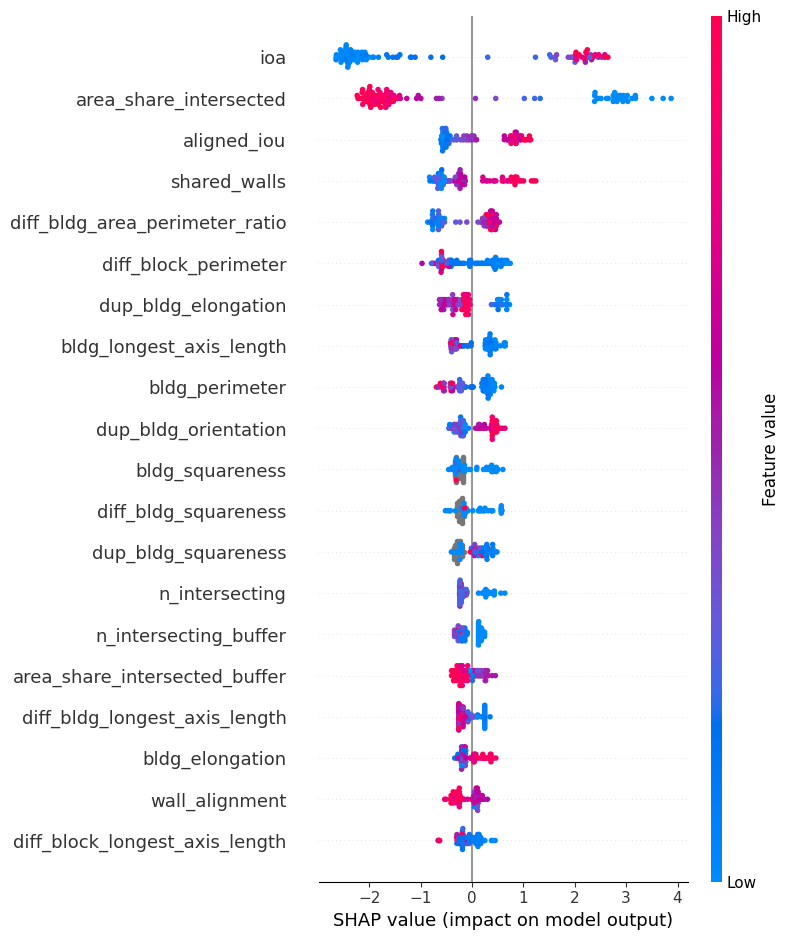

In [23]:
import shap
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(random_state=42, **HYPERPARAMETERS)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test, feature_names=fts)

In [129]:
# candidates.to_parquet('candidates-features.parquet')

candidates_old = gpd.read_parquet('candidates-features.parquet')
_percentage_diff(candidates.sort_index(), candidates_old.sort_index(), fts).sum().sort_values()



bldg_footprint_area                0.0
bldg_perimeter                     0.0
bldg_longest_axis_length           0.0
bldg_elongation                    0.0
bldg_orientation                   0.0
bldg_squareness                    0.0
bldg_convexity                     0.0
bldg_area_perimeter_ratio          0.0
diff_bldg_footprint_area           0.0
diff_bldg_perimeter                0.0
diff_bldg_longest_axis_length      0.0
diff_bldg_elongation               0.0
diff_bldg_orientation              0.0
diff_bldg_squareness               0.0
diff_bldg_convexity                0.0
diff_bldg_area_perimeter_ratio     0.0
dup_bldg_footprint_area            0.0
dup_bldg_perimeter                 0.0
dup_bldg_longest_axis_length       0.0
dup_bldg_elongation                0.0
dup_bldg_orientation               0.0
dup_bldg_squareness                0.0
dup_bldg_convexity                 0.0
dup_bldg_area_perimeter_ratio      0.0
diff_block_footprint_area          0.0
diff_block_perimeter     

In [276]:
bldg_features_diff = ['diff_' + ft for ft in bldg_features]
block_features_diff = ['diff_' + ft for ft in block_features]
fts = (
    # bldg_features 
    bldg_features_diff
    + bldg_features_dup
    + bldg_features_ref
    + block_features_diff
    + ['ioa']
    + ['aligned_iou']
    # + ['wall_alignment']
    + ['n_intersecting', 'n_intersecting_buffer', 'area_share_intersected', 'area_share_intersected_buffer']
)
bldg_features = ['bldg_footprint_area', 'bldg_perimeter', 'bldg_longest_axis_length', 'bldg_elongation', 'bldg_orientation'] + ['bldg_squareness', 'bldg_convexity', 'bldg_area_perimeter_ratio']
candidates = candidates.rename(columns={ft: 'ref_' + ft for ft in bldg_features})

_percentage_diff(candidates.sort_index(), candidates_old.sort_index(), fts).sum().sort_values()

# candidates[fts].isna().sum()
# candidates_old[fts].isna().sum()

diff_bldg_convexity                       -inf
diff_bldg_longest_axis_length    -5.170019e+03
diff_bldg_perimeter              -4.062139e+03
diff_bldg_footprint_area         -6.971724e+02
diff_bldg_area_perimeter_ratio   -6.695880e+02
diff_bldg_elongation             -2.284322e+02
diff_bldg_orientation            -8.158512e+01
diff_bldg_squareness             -1.679137e+01
dup_bldg_convexity               -2.739812e+00
n_intersecting_buffer            -1.449654e+00
block_orientation                -7.097080e-01
block_squareness                 -6.241390e-07
block_longest_axis_length        -7.421199e-08
ref_bldg_elongation              -3.333248e-09
ref_bldg_perimeter               -1.372101e-10
ref_bldg_convexity               -4.648120e-11
ref_bldg_longest_axis_length      1.421434e-11
ref_bldg_footprint_area           2.997585e-11
ref_bldg_area_perimeter_ratio     1.671858e-10
block_footprint_area              1.082962e-08
block_perimeter                   1.434039e-08
block_area_pe

In [324]:
candidates['duplicate_id_2'] = existing_buildings.groupby('candidate_id')['ioa_bsc'].idxmax()
candidates['duplicate_geometry_2'] = candidates['duplicate_id_2'].map(existing_buildings.drop_duplicates(subset='id')['geometry'])
candidates_changed = candidates[candidates['duplicate_id'] != candidates['duplicate_id_2']]


/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fnachtigall/workspace/eubucco-conflation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [306]:
# diff = _percentage_diff(candidates.sort_index(), candidates_old.sort_index(), fts)
changed_bldgs = diff.mean(axis=1).sort_values().head(8).index
candidates.loc[changed_bldgs]
# diff[diff['diff_bldg_longest_axis_length'] > 0.1]

,id,dataset,ioa,geometry,candidate_id,duplicate,candidate_dataset,dx,dy,old_geometry,duplicate_id,duplicate_geometry,bldg_footprint_area,bldg_perimeter,bldg_longest_axis_length,bldg_elongation,bldg_orientation,bldg_squareness,bldg_convexity,bldg_area_perimeter_ratio,aligned_iou,wall_alignment,diff_bldg_footprint_area,diff_bldg_perimeter,diff_bldg_longest_axis_length,diff_bldg_elongation,diff_bldg_orientation,diff_bldg_squareness,diff_bldg_convexity,diff_bldg_area_perimeter_ratio,shape_discreptancy,dup_bldg_footprint_area,dup_bldg_perimeter,dup_bldg_longest_axis_length,dup_bldg_elongation,dup_bldg_orientation,dup_bldg_squareness,dup_bldg_convexity,dup_bldg_area_perimeter_ratio,n_intersecting,area_share_intersected,n_intersecting_buffer,area_share_intersected_buffer,existing_block_geometry,block_geometry,block_footprint_area,block_perimeter,block_longest_axis_length,block_elongation,block_orientation,block_squareness,block_area_perimeter_ratio,duplicate_threshold,duplicate_xgboost
id_source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
austria-latest_4033753,v1-AT70934-143730,osm,0.129954,"POLYGON ((4452252.254 2674576.897, 4452256.634...",austria-latest_4033753,no,osm,0.080735,0.128967,"POLYGON ((4452252.173 2674576.768, 4452256.553...",15968,"POLYGON ((4452257.49 2674581.076, 4452257.491 ...",29.879196,21.928032,7.814827,0.841678,44.487561,NaN,1.000000,1.362603,0.140772,0.524285,-0.859228,-0.624744,-0.626411,-0.005094,-0.007676,NaN,-4.440892e-16,-0.624864,0.392574,212.252027,58.434788,20.918249,0.845987,44.831678,NaN,1.000000,3.632289,1.0,0.961480,1.0,0.710974,"POLYGON ((4452258.921 2674581.056, 4452247.694...","POLYGON ((4452261.439 2674577.197, 4452255.836...",0.188569,0.166313,0.171791,-0.186392,-0.027716,1.866400,0.019082,True,0
31331133_17756833,31331133_17756833,msft,0.000000,"POLYGON ((3533041.14 2743474.708, 3533035.542 ...",31331133_17756833,no,msft,-0.871953,0.183640,"POLYGON ((3533042.012 2743474.524, 3533036.413...",pays-de-la-loire-latest_2432924,"POLYGON ((3533071.558 2743423.969, 3533074.201...",22.167069,19.261372,6.971350,0.651443,16.045553,0.237968,1.000000,1.150856,0.252505,0.000000,-0.454057,-0.385902,-0.466795,1.429896,-0.415365,NaN,-6.661338e-16,-0.110983,0.466143,40.603259,31.365324,13.074428,0.268095,27.445398,NaN,1.000000,1.294527,1.0,0.395266,1.0,0.861739,"POLYGON ((3533041.633 2743478.785, 3533051.357...","POLYGON ((3533028.484 2743461.426, 3533030.741...",1.040940,0.665886,0.402364,0.447911,-0.282346,-0.344082,0.225137,False,0
120212300_2402795,120212300_2402795,msft,0.000000,"POLYGON ((4608967.862 3055517.015, 4608969.978...",120212300_2402795,no,msft,-1.437221,-2.715117,"POLYGON ((4608969.299 3055519.73, 4608971.415 ...",czech-republic-latest_2451309,"POLYGON ((4608950.306 3055569.683, 4608951.112...",35.061633,23.694990,8.389509,0.942210,20.320180,0.117770,1.000000,1.479707,0.693972,0.000000,-0.007344,-0.016721,-0.037153,0.419854,1.429112,-0.806373,2.539013e-03,0.009536,0.341079,35.321035,24.097932,8.713235,0.663597,8.365271,0.608231,0.997467,1.465729,1.0,0.752040,1.2,0.832723,"POLYGON ((4608965.364 3055541.242, 4608967.643...","POLYGON ((4608954.21 3055503.366, 4608957.098 ...",-0.588163,-0.525806,-0.553678,0.878208,0.521865,-0.469984,-0.131500,False,0
ile-de-france-latest_2158740,v1-FR93071-310620,osm,0.293705,"POLYGON ((3774329.28 2895922.57, 3774330.217 2...",ile-de-france-latest_2158740,yes,osm,0.301558,-0.075562,"POLYGON ((3774328.978 2895922.645, 3774329.915...",BATIMENT0000000243823200,"POLYGON ((3774329.613 2895918.681, 3774329.977...",3.830777,9.710192,4.011516,0.257843,4.848723,NaN,1.000000,0.394511,0.966246,0.831379,-0.005104,0.000179,-0.004620,0.007095,-0.094318,NaN,-3.330669e-16,-0.005282,0.016657,3.850429,9.708456,4.030135,0.256027,5.353671,2.979983,1.000000,0.396606,1.0,0.728778,1.8,0.891701,"POLYGON ((3774341.493 2895911.531, 3774340.445...","POLYGON ((3774340.734 2895911.31, 3774339.82 2...",0.000485,-0.000627,0.001278,-0.012949,-0.107224,-0.660537,0.001112,True,1
midi-p

In [ ]:
plot_building_pairs(candidates_old.loc[changed_bldgs], 3, 3)

In [339]:
some_id = candidates_changed[candidates_changed['duplicate'] == 'no'].iloc[25]['candidate_id']
m = gdf[(gdf['candidate_id'] == some_id)].explore()
gdf.loc[[some_id]].explore(m=m, color='red')

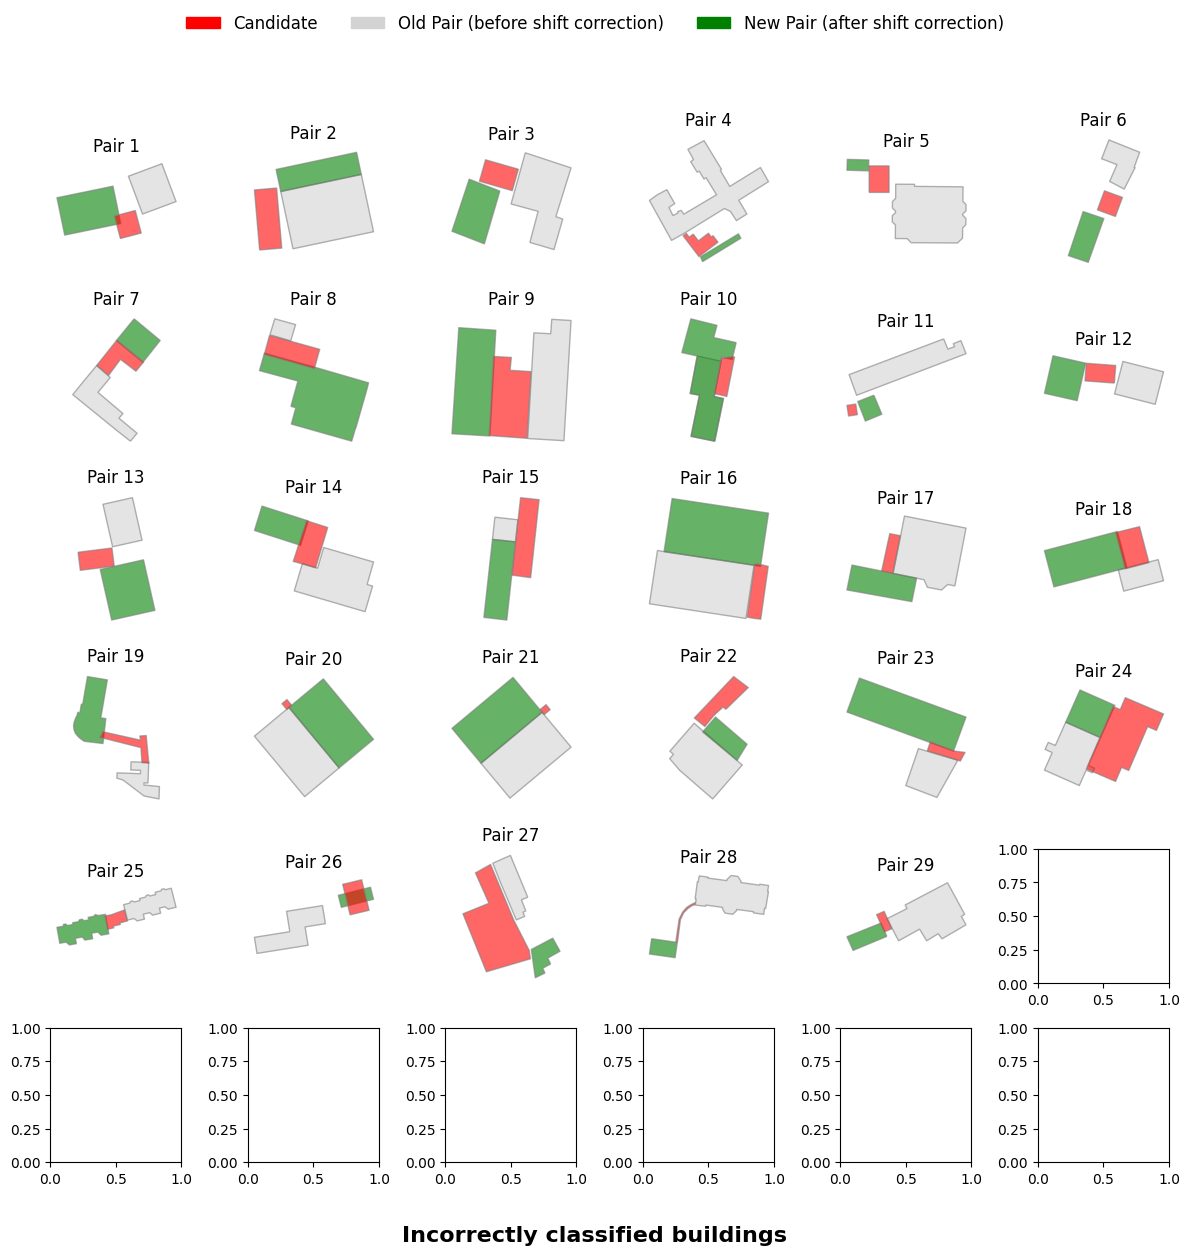

In [338]:

def plot_changed_pairs(gdf, nrows, ncols):
    # Create a 4x4 subplot grid
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    axes = axes.flatten()  # Flatten to iterate easily
    if nrows * ncols < len(gdf):
        gdf = gdf.sample(nrows * ncols, random_state=42)

    # Define colors
    candidate_color = 'red'
    old_pair_color = "lightgray"
    new_pair_color = "green"

    # Plot each geometry pair in a subplot
    for idx, (ax, (_, row)) in enumerate(zip(axes, gdf.iterrows())):
        gpd.GeoSeries(row['duplicate_geometry_2']).plot(ax=ax, color=old_pair_color, alpha=0.6, edgecolor='gray')
        gpd.GeoSeries(row['duplicate_geometry']).plot(ax=ax, color=new_pair_color, alpha=0.6, edgecolor='gray')
        gpd.GeoSeries(row['geometry']).plot(ax=ax, color=candidate_color, alpha=0.6, edgecolor='gray')
        
        ax.set_title(f"Pair {idx+1}")
        ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Add legend
    legend_patches = [
        mpatches.Patch(color=candidate_color, label="Candidate"),
        mpatches.Patch(color=old_pair_color, label="Old Pair (before shift correction)"),
        mpatches.Patch(color=new_pair_color, label="New Pair (after shift correction)"),
    ]
    fig.legend(handles=legend_patches, loc="upper center", ncol=3, fontsize=12, frameon=False)
    fig.suptitle("Incorrectly classified buildings", fontsize=16, y=-0.02, fontweight="bold")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

plot_changed_pairs(candidates_changed[candidates_changed['duplicate'] == 'no'], 6, 6)

<Axes: >

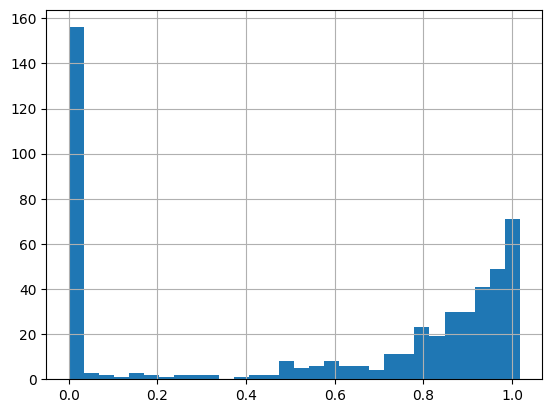

In [236]:
candidates['area_share_intersected'].hist(bins=30)

<Axes: >

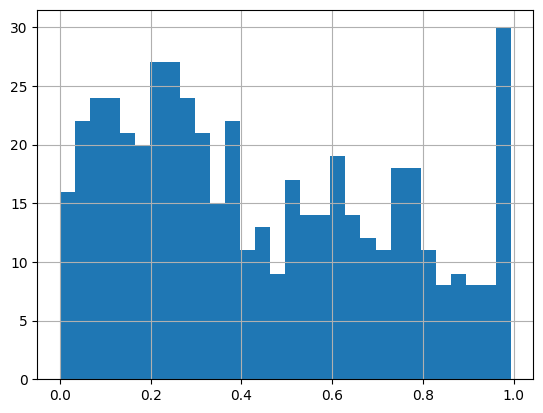

In [234]:
candidates['aligned_iou'].hist(bins=30)

<Axes: >

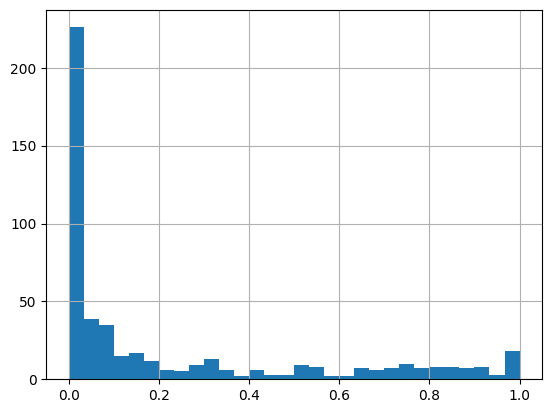

In [235]:
candidates['ioa'].hist(bins=30)

(0.0, 0.2)

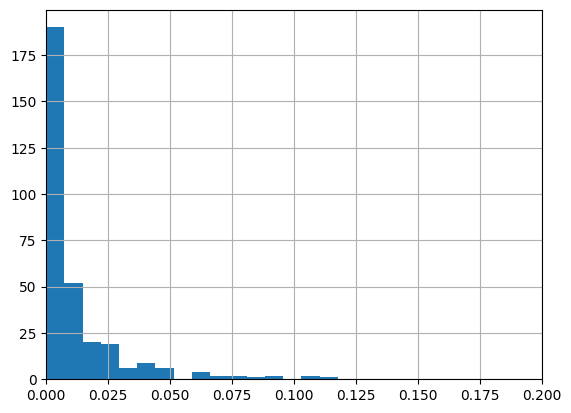

In [510]:
candidates_only[candidates_only['duplicate'] == 'no']['ioa'].hist(bins=100).set_xlim(0, 0.2)

### Analysis of mispredictions

In [857]:
def plot_bldg_pairs(bldgs):
    map1 = bldgs.explore(color='blue', alpha=0.5)
    map2 = bldgs.set_geometry('duplicate_geometry').explore(m=map1, column='shape_discreptancy', alpha=0.3)
    return map2

# plot_bldg_pairs(candidates.head(100))

In [201]:
existing_buildings[existing_buildings['candidate_id'] == '120322103_5616294'].explore('n_intersecting')

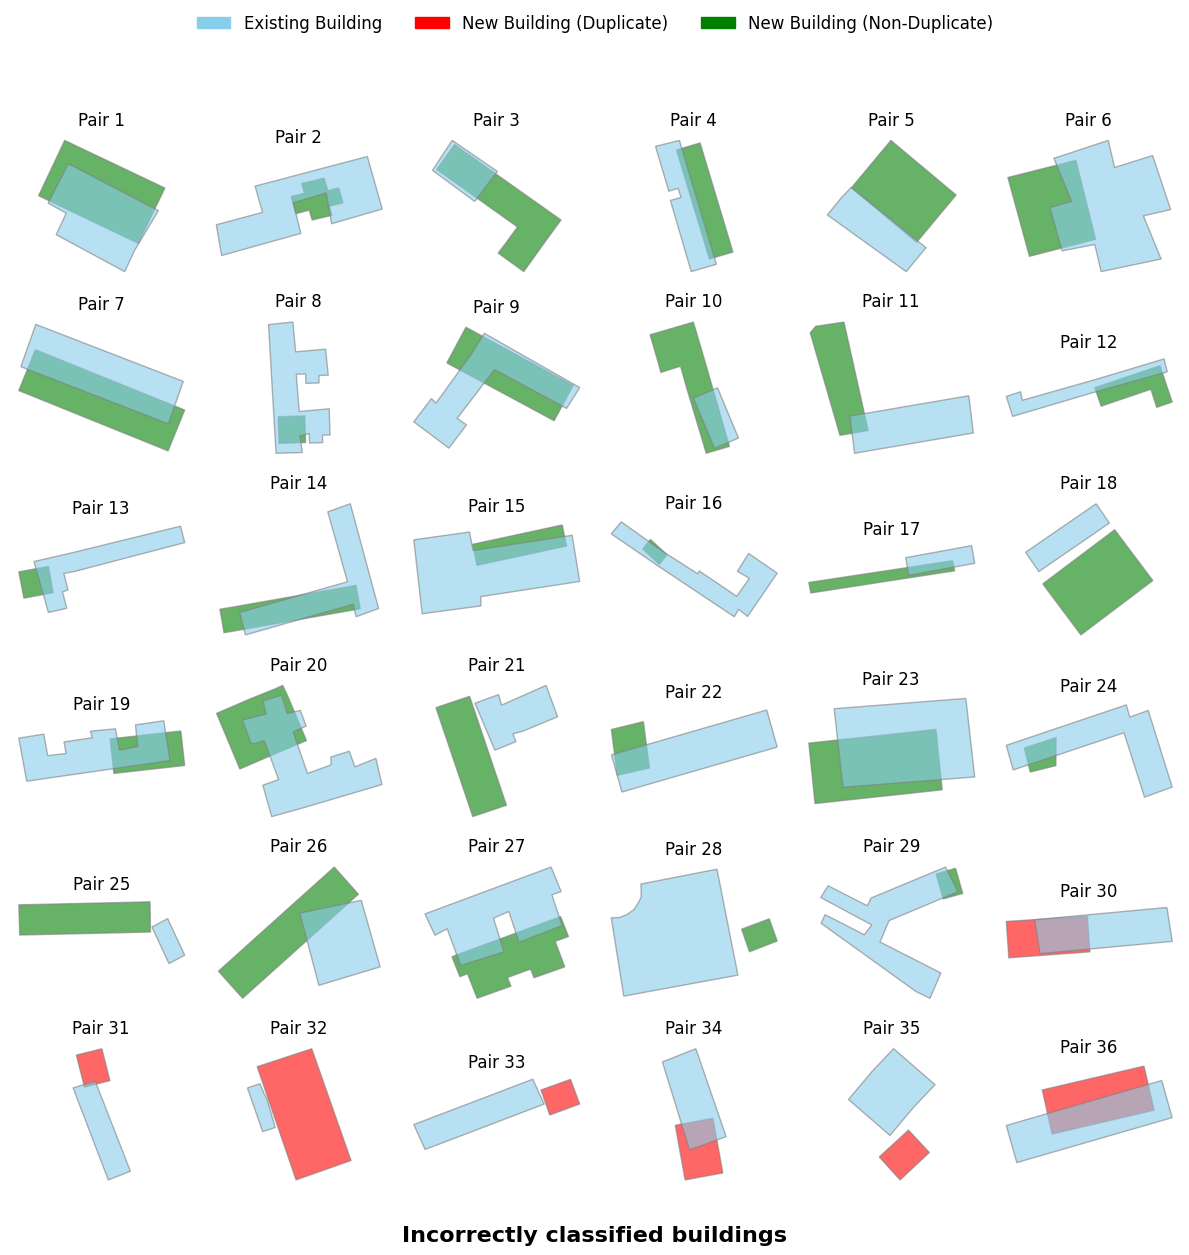

In [37]:



candidates['duplicate_bool'] = candidates['duplicate'] == 'yes'
candidates_false = candidates[candidates['duplicate_xgboost'] != candidates['duplicate_bool']]

def plot_building_pairs(gdf, nrows, ncols):
    # Create a 4x4 subplot grid
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    axes = axes.flatten()  # Flatten to iterate easily
    if nrows * ncols < len(gdf):
        gdf = gdf.sample(nrows * ncols, random_state=42)

    gdf = gdf.sort_values('duplicate')

    # Define colors
    existing_color = "skyblue"
    duplicate_colors = {'yes': "red", 'no': "green"}

    # Plot each geometry pair in a subplot
    for idx, (ax, (_, row)) in enumerate(zip(axes, gdf.iterrows())):
        gpd.GeoSeries(row['geometry']).plot(ax=ax, color=duplicate_colors[row['duplicate']], alpha=0.6, edgecolor='gray', label="Geometry")
        gpd.GeoSeries(row['duplicate_geometry']).plot(ax=ax, color=existing_color, alpha=0.6, edgecolor='gray', label="Duplicate Geometry")
        # geom = row['geometry'].simplify(0.1).buffer(2, join_style='mitre')
        # gpd.GeoSeries(geom).plot(ax=ax, color=existing_color, alpha=0.6, edgecolor='gray', label="Duplicate Geometry")
        
        ax.set_title(f"Pair {idx+1}")
        ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Add legend
    legend_patches = [
        mpatches.Patch(color=existing_color, label="Existing Building"),
        mpatches.Patch(color=duplicate_colors['yes'], label="New Building (Duplicate)"),
        mpatches.Patch(color=duplicate_colors['no'], label="New Building (Non-Duplicate)")
    ]
    fig.legend(handles=legend_patches, loc="upper center", ncol=3, fontsize=12, frameon=False)
    fig.suptitle("Incorrectly classified buildings", fontsize=16, y=-0.02, fontweight="bold")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

plot_building_pairs(candidates_false, 6, 6)

In [ ]:

# def iteratively_plot_labeled_buildings(candidates, existing_buildings, other_new_buildings, delay=3):
    # for i, (candidate_id, row) in enumerate(candidates.to_crs('EPSG:4326').iterrows()):

def iteratively_plot_labeled_buildings(candidates, existing_buildings, other_new_buildings):

    def show_duplicate_candidate(i):
        """Display a potential building duplicate and its neighbors for labeling"""
        if i >= len(candidates):
            print("All buildings labeled!")
            return

        # Clear output to refresh map and widgets
        display.clear_output(wait=True)
        
        display_map(i)
        _display_button(i, show_duplicate_candidate)

        # time.sleep(3)
        # show_duplicate_candidate(i+1)

    def display_map(i):
        if i >= len(candidates):
            print("All buildings labeled!")
            return

        candidate_id = candidates.index[i]
        duplicate = candidates.iloc[i].duplicate
        centroid = candidates.iloc[i].geometry.centroid
        location = [centroid.y, centroid.x]

        gdf_neighbors_existing = existing_buildings[existing_buildings['candidate_id'] == candidate_id]
        gdf_neighbors_new = other_new_buildings[other_new_buildings['candidate_id'] == candidate_id]

        duplicate_colors = {'yes': "red", 'no': "green", 'unsure': "gray"}
        m = folium.Map(location=location, zoom_start=20, tiles="CartoDB Positron")
        m = gdf_neighbors_existing.explore(m=m, color='skyblue', style_kwds={"fillOpacity": 0.7})
        m = gdf_neighbors_new.explore(m=m, color='coral', style_kwds={"fillOpacity": 0.2})

        m = candidates.loc[[candidate_id]].explore(m=m, color=duplicate_colors[duplicate], style_kwds={"fill": False, 'weight': 3})

        # m = candidates.loc[[candidate_id]].explore(m=m, column='wall_alignment', vmin=0, vmax=1, style_kwds={"fill": False, 'weight': 3})
        # m = candidates.loc[[candidate_id]].set_geometry('block_geometry').explore(m=m, color='red', style_kwds={"fillOpacity": 0.6, 'weight': 5})
        # m = candidates.loc[[candidate_id]].set_geometry('existing_block_geometry').explore(m=m, color='skyblue', style_kwds={"fillOpacity": 0.6, 'weight': 5})

        # duplicate_labels = {'yes': f"{i}: Duplicate", 'no': f"{i}: Not a duplicate", 'unsure': f"{i}: Unsure"}
        duplicate_labels = {'yes': f"Duplicate", 'no': f"Not a duplicate", 'unsure': f"Unsure"}
        folium.Marker(
            location=location,
            icon=DivIcon(
                icon_size=(150, 36),
                icon_anchor=(20, 60),
                html=f'<div style="font-size: 14pt; color: {duplicate_colors[duplicate]}; font-weight: bold;">{duplicate_labels[duplicate]}</div>',
            )
        ).add_to(m)
        display.display(m)

    def _display_button(i, action):
        """Display next button"""
        previous_button = widgets.Button(description="Previous", button_style="info")
        next_button = widgets.Button(description="Next", button_style="success")
        previous_button.on_click(lambda _: action(i-1))
        next_button.on_click(lambda _: action(i+1))
        display.display(widgets.HBox([previous_button, next_button]))


    show_duplicate_candidate(0)

display.clear_output(wait=True)
iteratively_plot_labeled_buildings(candidates[candidates['duplicate'] == 'no'].sample(frac=1, random_state=1).to_crs('EPSG:4326'), existing_buildings, other_new_buildings)

In [ ]:
candidates_false['duplicate'].value_counts()

duplicate
unsure    328
no        317
yes       190
Name: count, dtype: int64

In [7]:
# sample = candidates_false.sample(30, random_state=42)#.sort_values('duplicate')
sample = candidates[candidates['duplicate'] == 'unsure'].sample(30, random_state=42)#.sort_values('duplicate')
# sample = candidates_false.sample(36, random_state=42).sort_values('duplicate').iloc[[18]]
# iteratively_plot_labeled_buildings(sample, existing_buildings, other_new_buildings, delay=5)

In [1144]:
sample = candidates_false.sample(30, random_state=42).sort_values('duplicate').iloc[[13]]
sample = candidates[candidates['n_intersecting'] > 2].sample(30, random_state=0)
# sample = candidates_false.sample(36, random_state=42).sort_values('duplicate').iloc[[18]]
iteratively_plot_labeled_buildings(sample, existing_buildings, other_new_buildings, delay=5)

KeyboardInterrupt: 

### Prototyping alignment feature

/usr/local/Caskroom/miniconda/base/envs/eubucco-features/lib/python3.10/site-packages/geopandas/geoseries.py:720: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


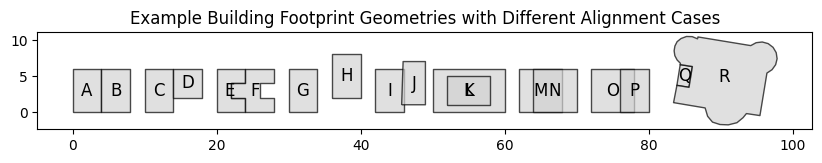

In [1355]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import translate

example = new_buildings.loc[['nordrhein-westfalen-latest_6879032', 'nordrhein-westfalen-latest_581305']].geometry
example = example.apply(
    lambda row: translate(row, xoff=-example[0].centroid.x+85, yoff=-example[0].centroid.y+5)
)
example
# Define building footprints
buildings = [
    # Case 1: Perfectly aligned shared wall
    Polygon([(0, 0), (4, 0), (4, 6), (0, 6), (0, 0)]),  # Building A
    Polygon([(4, 0), (8, 0), (8, 6), (4, 6), (4, 0)]),  # Building B
    
    # Case 2: Partially aligned shared wall
    Polygon([(10, 0), (14, 0), (14, 6), (10, 6), (10, 0)]),  # Building C
    Polygon([(14, 2), (18, 2), (18, 6), (14, 6), (14, 2)]),  # Building D (offset)

    # Case 3: Detailed indentation matching
    Polygon([(20, 0), (24, 0), (24, 2), (22, 2), (22, 4), (24, 4), (24, 6), (20, 6), (20, 0)]),  # Building E
    Polygon([(24, 0), (28, 0), (28, 2), (26, 2), (26, 4), (28, 4), (28, 6), (24, 6), (24, 4), (22, 4), (22, 2), (24, 2), (24, 0)]),  # Building F (matching indentation)

    # Case 4: No alignment
    Polygon([(30, 0), (34, 0), (34, 6), (30, 6), (30, 0)]),  # Building G
    Polygon([(36, 2), (40, 2), (40, 8), (36, 8), (36, 2)]),  # Building H (completely separate)

    # Case 5: Imperfect alignment (walls not parallel, slight overlap)
    Polygon([(42, 0), (46, 0), (46, 6), (42, 6), (42, 0)]),  # Building I
    Polygon([(45.7, 1), (49, 1), (49, 7), (45.9, 7), (45.7, 1)]),   # Building J (not perfectly parallel, overlap at one end)
    
     # Case 6: Containment (one building contained within the other)
    Polygon([(50, 0), (60, 0), (60, 6), (50, 6), (50, 0)]),  # Building K (larger)
    Polygon([(52, 1), (58, 1), (58, 5), (52, 5), (52, 1)]),  # Building L (smaller, contained in K)

    # Case 7: Large overlap (>50%)
    Polygon([(62, 0), (68, 0), (68, 6), (62, 6), (62, 0)]),  # Building M
    Polygon([(64, 0), (70, 0), (70, 6), (64, 6), (64, 0)]),  # Building N (large overlap with M)

    # Case 7: Large overlap (>50%)
    Polygon([(72, 0), (78, 0), (78, 6), (72, 6), (72, 0)]),  # Building M
    Polygon([(76, 0), (80, 0), (80, 6), (76, 6), (76, 0)]),  # Building N (large overlap with M)

    *example,
]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=buildings)
gdf1 = gdf.iloc[::2].reset_index(drop=True)
gdf2 = gdf.iloc[1::2].reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, edgecolor='black', facecolor='lightgray', alpha=0.7)

# Labels
for idx, poly in enumerate(gdf.geometry):
    x, y = poly.centroid.xy
    ax.text(x[0], y[0], f"{chr(65+idx)}", fontsize=12, ha='center', va='center', color='black')

ax.set_title("Example Building Footprint Geometries with Different Alignment Cases")
plt.show()


<Axes: >

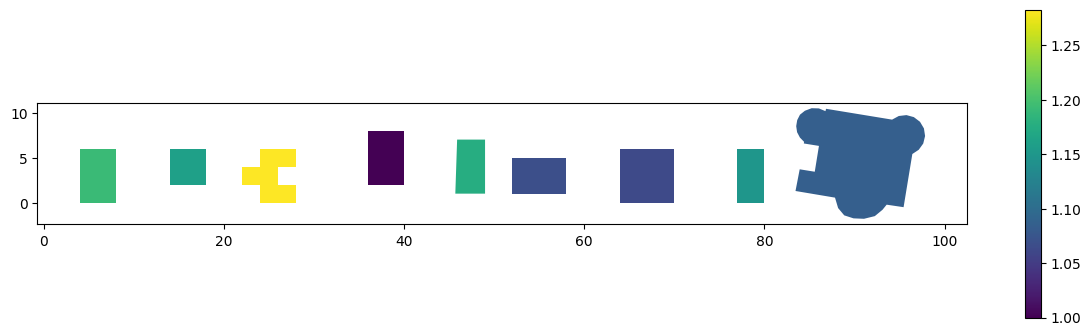

In [1340]:
gdf2['alignment'] = gdf1.union(gdf2).area / gdf1.buffer(1).union(gdf2.buffer(1)).area
gdf2['degree_of_intersection'] = (gdf1.area + gdf2.area) / gdf1.union(gdf2).area #* gdf1.buffer(1).union(gdf2.buffer(1)).area
gdf2['degree_of_shared_border'] = (gdf1.buffer(1).area + gdf2.buffer(1).area) / gdf1.union(gdf2).buffer(1).area
gdf2['alignment'] = gdf2['degree_of_shared_border'] / gdf2['degree_of_intersection']
gdf2.plot('alignment', legend=True, figsize=(15, 8), legend_kwds={'shrink': 0.5})


In [ ]:

gdf2['max_possible_perfectly_enclosed_buffered_union_area'] = np.maximum((gdf1.area + gdf2.buffer(1).area), (gdf1.buffer(1).area + gdf2.area))
gdf2['max_possible_buffered_union_area'] = (gdf1.buffer(1).area + gdf2.buffer(1).area)
gdf2['actual_buffered_union_area'] = gdf1.union(gdf2).buffer(1).area
# gdf2['alignment'] = (gdf2['max_possible_buffered_union_area'] / gdf2['actual_buffered_union_area']) * (gdf2['max_possible_perfectly_enclosed_buffered_union_area'] / gdf2['actual_buffered_union_area'] )
gdf2['alignment2'] = (gdf2['actual_buffered_union_area']) / gdf2['max_possible_perfectly_enclosed_buffered_union_area']

gdf2['max_possible_saved_buffer_area'] = np.minimum(gdf1.buffer(1).difference(gdf1).area, gdf2.buffer(1).difference(gdf2).area)
gdf2['alignment2'] = (gdf2['max_possible_buffered_union_area'] - (gdf2['actual_buffered_union_area'])) / gdf2['max_possible_saved_buffer_area'] 

# SOLUTION!!!!
# interpretation of formula: 
# alignment tolerance of up to 1m 
# saving of buffer area must be bigger than intersection area
# normalize with potential saving to account for different building sizes

# def calculate_wall_alignment(geoms1, geoms2): -> see above
    
gdf2['alignment'] = calculate_wall_alignment(gdf1, gdf2)

ax = gdf2.plot('alignment', legend=True, figsize=(15, 8), legend_kwds={'shrink': 0.5})

for x, y, label in zip(gdf2.centroid.x, gdf2.centroid.y, gdf2['alignment']):
    ax.text(x, y, round(label, 2), fontsize=8, ha='right')

plt.show()


## GNN approach

In [57]:
def get_nearest_neighbors_kd(gdf1, gdf2, k):
    coordinates1 = np.array([[point.x, point.y] for point in gdf1.centroid])
    coordinates2 = np.array([[point.x, point.y] for point in gdf2.centroid])

    tree = KDTree(coordinates2)

    # Find 5 nearest neighbors for each point
    distances, indices = tree.query(coordinates1, k=k+1)

    return indices, distances

# Get the 20 nearest neighbors for each candidate building
candidate_geometry = gpd.GeoSeries(new_buildings['candidate_id'].map(candidates['geometry']))
new_buildings['candidate_distance'] = new_buildings['geometry'].distance(candidate_geometry)
gnn_candidate_idx = new_buildings.groupby('candidate_id', group_keys=False)['candidate_distance'].nsmallest(20).index
gnn_candidates = new_buildings.loc[gnn_candidate_idx]

# Get the 5 nearest neighbors for each new building (PROBLEM: we include existing buildings for which we do not include the respective new building)
indices, distances = get_nearest_neighbors_kd(gnn_candidates, existing_buildings, 5)
gnn_existing_buildings = existing_buildings.iloc[np.unique(indices.flatten())]

In [80]:
# use full geometry for distance calculation (not centroid) to avoid accidentially excluding very large buildings
candidate_location = gpd.GeoSeries(new_buildings['candidate_id'].map(candidates.geometry))
new_buildings['candidate_distance'] = new_buildings.geometry.distance(candidate_location)

candidate_location = gpd.GeoSeries(existing_buildings['candidate_id'].map(candidates.geometry))
existing_buildings['candidate_distance'] = existing_buildings.geometry.distance(candidate_location)

gnn_candidates = new_buildings[new_buildings['candidate_distance'] < 50]
gnn_existing_buildings = existing_buildings[existing_buildings['candidate_distance'] < 50]


In [206]:
from IPython import display
import time

def iteratively_plot_groups(new_buildings, existing_buildings, delay=3):
    candidate_ids = new_buildings['candidate_id'].unique()
    candidate_ids = list(new_buildings['candidate_id'].value_counts().head(100).index)
    existing_groups = existing_buildings.groupby("candidate_id")
    new_groups = new_buildings.groupby("candidate_id")

    for id in candidate_ids:
        # m = existing_groups.get_group(id).set_crs(existing_buildings.crs).explore(color='skyblue', style_kwds={"fillOpacity": 0.7})
        m = existing_groups.get_group(id).set_crs(existing_buildings.crs).explore('n_intersecting', style_kwds={"fillOpacity": 0.7})
        m = new_groups.get_group(id).set_crs(new_buildings.crs).explore(m=m, color='coral', style_kwds={"fillOpacity": 0.2})
        display.clear_output(wait=True)
        display.display(m)
        time.sleep(delay)

# iteratively_plot_groups(candidates, existing_buildings)
candidates.columns[candidates.columns.duplicated()]
candidates[['ioa', 'aligned_iou', 'wall_alignment', 'diff_bldg_footprint_area',
       'diff_bldg_perimeter', 'diff_bldg_longest_axis_length',
       'diff_bldg_elongation', 'diff_bldg_orientation', 'diff_bldg_squareness',
       'diff_bldg_convexity', 'diff_bldg_area_perimeter_ratio',
       'shape_discreptancy']]
# iteratively_plot_groups(gnn_candidates, gnn_existing_buildings)

,ioa,ioa,aligned_iou,aligned_iou,wall_alignment,wall_alignment,diff_bldg_footprint_area,diff_bldg_footprint_area,diff_bldg_perimeter,diff_bldg_perimeter,diff_bldg_longest_axis_length,diff_bldg_longest_axis_length,diff_bldg_elongation,diff_bldg_elongation,diff_bldg_orientation,diff_bldg_orientation,diff_bldg_squareness,diff_bldg_squareness,diff_bldg_convexity,diff_bldg_convexity,diff_bldg_area_perimeter_ratio,diff_bldg_area_perimeter_ratio,shape_discreptancy,shape_discreptancy
id_source,,,,,,,,,,,,,,,,,,,,,,,,
120322103_5616294,NaN,0.000000,0.121535,0.121535,2.699285e-01,2.699285e-01,-0.878465,-0.878465,-0.652496,-0.652496,-0.653015,-0.653015,0.056398,0.056398,-0.195229,-0.195229,NaN,NaN,5.551115e-16,5.551115e-16,-0.650263,-0.650263,0.440838,0.440838
120322110_8421715,NaN,0.925170,0.599531,0.599531,-1.956265e+00,-1.956265e+00,0.468326,0.468326,0.428603,0.428603,0.325490,0.325490,-0.213867,-0.213867,0.392517,0.392517,-0.983127,-0.983127,-7.857439e-03,-7.857439e-03,0.027805,0.027805,0.355949,0.355949
120322111_2595230,NaN,0.000000,0.423942,0.423942,3.338018e-15,3.338018e-15,-0.520881,-0.520881,-0.310393,-0.310393,-0.311377,-0.311377,0.032420,0.032420,-0.489826,-0.489826,NaN,NaN,-2.220446e-16,-2.220446e-16,-0.305229,-0.305229,0.281447,0.281447
120322101_9394472,NaN,0.770114,0.412946,0.412946,-2.061993e-01,-2.061993e-01,1.421623,1.421623,0.579145,0.579145,0.603660,0.603660,-0.247152,-0.247152,0.289926,0.289926,NaN,NaN,-4.440892e-16,-4.440892e-16,0.533502,0.533502,0.525001,0.525001
120322111_2660504,NaN,0.000000,0.164990,0.164990,1.542432e-01,1.542432e-01,-0.835010,-0.835010,-0.588525,-0.588525,-0.584069,-0.584069,-0.136136,-0.136136,0.085372,0.085372,NaN,NaN,0.000000e+00,0.000000e+00,-0.599028,-0.599028,0.404020,0.404020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
centro-latest_797940,NaN,0.641889,0.732136,0.732136,-8.101648e-01,-8.101648e-01,0.365867,0.365867,0.166724,0.166724,0.165333,0.165333,0.022824,0.022824,0.020510,0.020510,NaN,NaN,2.220446e-16,2.220446e-16,0.170685,0.170685,0.130278,0.130278
centro-latest_2586641,NaN,0.710420,0.925887,0.925887,-7.439437e-01,-7.439437e-01,0.070277,0.070277,0.041340,0.041340,0.065805,0.065805,0.019852,0.019852,-0.119506,-0.119506,NaN,NaN,1.237646e-02,1.237646e-02,0.027788,0.027788,0.050992,0.050992
centro-latest_2207844,NaN,0.865528,0.884235,0.884235,-1.760382e+00,-1.760382e+00,0.075344,0.075344,0.018974,0.018974,0.027373,0.027373,-0.048364,-0.048364,-0.016017,-0.016017,NaN,NaN,2.683957e-02,2.683957e-02,0.055320,0.055320,0.038319,0.038319


In [ ]:
gnn_existing_buildings

## DEPRECATED

In [ ]:
neighbor_geoms = existing_buildings[~existing_buildings.index.duplicated(keep='first')]['geometry']
candidates['ioa'] = existing_buildings.groupby('candidate_id')['ioa'].max()
# candidates['duplicate_geometry'] = existing_buildings.groupby('candidate_id').apply(lambda g: g.loc[g['ioa'].idxmax()].geometry)

# After correcting local shift, not all candidates may intersect with another building anymore. Instead use nearest building.
candidates['duplicate_id'] = existing_buildings[existing_buildings['ioa'] > 0].groupby('candidate_id')['ioa'].idxmax()
candidates['duplicate_id'] = candidates['duplicate_id'].fillna(existing_buildings.groupby('candidate_id')['candidate_distance'].idxmin())
candidates['duplicate_geometry'] = neighbor_geoms.loc[candidates['duplicate_id']].values

In [ ]:
    # geoms = buildings[["geometry"]]
    # touching = gpd.sjoin(geoms, geoms, predicate="intersects")
    # touching = touching[touching.index != touching["id_source_right"]]

    # graph = nx.Graph()
    # graph.add_edges_from(zip(touching.index, touching["id_source_right"]))




# def calculate_area_intersected(candidates, existing_buildings):
#     """For each existing building, calculate the share of the footprint area that is intersected by new buildings"""
#     existing_building_idx, candidate_idx = candidates.sindex.query(existing_buildings.geometry)

#     candidate_geoms = candidates.iloc[candidate_idx].geometry
#     existing_geoms = existing_buildings.iloc[existing_building_idx].geometry
#     ioa = candidate_geoms.intersection(existing_geoms, align=False).area# / np.minimum(existing_geoms.area, candidate_geoms.area)

#     # match = ioa.loc[ioa.groupby(level=0).idxmax()]

#     return ioa

# calculate_area_intersected(candidates, existing_buildings)



def calculate_spatial_interaction_features(gdf1, gdf2):
    new_buildings_unq = other_new_buildings.reset_index().drop_duplicates(subset='id_source').set_index('id_source')
    existing_buildings_unq = existing_buildings.reset_index().drop_duplicates(subset='id_source').set_index('id_source')

    existing_buildings_unq['area_share_intersected'] = calculate_area_intersected(existing_buildings_unq, new_buildings_unq)
    existing_buildings_unq['n_intersecting'] = count_intersecting_buildings(existing_buildings_unq, new_buildings_unq)

    return existing_buildings_unq